In [1]:
import argparse
import numpy as np
import os
import tabulate
import torch
import torch.nn.functional as F
import torch.nn

import data
import models
import curves
import utils

import pickle
from pylab import rcParams

In [2]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

from scipy.stats import norm

import utils
import time
from torch import nn
import seaborn as sns
from sklearn.manifold import TSNE

In [8]:
def distance(model1, model2):
    par1 = np.concatenate([p.data.cpu().numpy().ravel() for p in model1.parameters()])
    par2 = np.concatenate([p.data.cpu().numpy().ravel() for p in model2.parameters()])
    u = par2 - par1
    dx = np.linalg.norm(u)
    return dx

In [9]:
def get_vector(model1):
    par1 = np.concatenate([p.data.cpu().numpy().ravel() for p in model1.parameters()])
    return par1

In [10]:
from pylab import rcParams
rcParams['figure.figsize'] = 12, 10
rcParams['figure.dpi'] = 100

In [11]:
def get_model(W, B, architecture):
    model_sampled = architecture.base(num_classes=10, **architecture.kwargs)
    model_samples = np.array(W) #.cpu().data.numpy()
    SIZE = model_sampled.middle_dim

    offset = 0
    for parameter in list(model_sampled.parameters())[:-1]:
        size = int(np.prod(parameter.size())/SIZE)
        value = model_samples[:, offset:offset+size]
        if size==10 or size==1:
             value = value.T
#         print(value.shape)
        value = value.reshape(parameter.size())
#         print(value.shape)
        parameter.data.copy_(torch.from_numpy(value))
        offset += size

    list(model_sampled.parameters())[-1].data.copy_(B.mean(0)) #torch.from_numpy(
    
    return model_sampled

def test(model):
    criterion = F.cross_entropy
    regularizer = None 
    train_res = utils.test(loaders['train'], model, criterion, regularizer)
    test_res = utils.test(loaders['test'], model, criterion, regularizer) 
    print(train_res)
    print(test_res)

def samples(model):
    p1 = list(model.parameters())[0].data.cpu().numpy()
    p2 = list(model.parameters())[1].data.cpu().numpy()
    p3 = list(model.parameters())[2].transpose(0,1).data.cpu().numpy()
    samples = np.hstack([p1, p2[:, None], p3])
    
    return samples

In [12]:
def plot_singl_values(model1, model2, plot=False):
    W11 = list(model1.parameters())[0].data.numpy()
    W12 = list(model1.parameters())[2].data.numpy()
    W21 = list(model2.parameters())[0].data.numpy()
    W22 = list(model2.parameters())[2].data.numpy()

    _, s11, _ = np.linalg.svd(W11)
    _, s12, _ = np.linalg.svd(W12)
    _, s21, _ = np.linalg.svd(W21)
    _, s22, _ = np.linalg.svd(W22)

    if plot:
        fig, axes = plt.subplots(2, 2,)
        axes[0, 0].set_title('W1 model1')
        axes[0, 0].plot(s11)
        axes[0, 1].set_title('W2 model1')
        axes[0, 1].plot(s12)
        axes[1, 0].set_title('W1 model2')
        axes[1, 0].plot(s21)
        axes[1, 1].set_title('W2 model2')
        axes[1, 1].plot(s22)
        plt.show()
    
    return s11, s12, s21, s22

In [13]:
def look_at_models(model1, model2, model3, model4, architecture):
    
    print("distance between train models", distance(model1, model2))
    print("distance between initial models", distance(model3, model4))
    print("how far model1 go", distance(model1, model3))
    print("how far model2 go", distance(model2, model4))
    
    rcParams['figure.figsize'] = 12, 10
    rcParams['figure.dpi'] = 100
    
    print('initial singular values')
    s111, s12, s21, s22 = plot_singl_values(model3, model4, plot=False)
    
    print('train singular values')
    s112, s12, s21, s22 = plot_singl_values(model1, model2, plot=False)
    
    print('singular values distribution')
    plt.hist(s111, bins = 50, density=False);
    plt.hist(s112, bins = 50, density=False);
    plt.show()
    
    sns.kdeplot(s111, shade=True,  cbar=True)
    sns.kdeplot(s112, shade=True,  cbar=True)
    plt.show()
    
    print('train models eigenvector heatmap')
    heat_image(model1)
    heat_image(model2)
    
    
    print('scalar product between train models')
    w1 = get_vector(model1)
    w2 = get_vector(model2)
    print('norms w1, w2', np.linalg.norm(w1), np.linalg.norm(w2))
    print('cos', (w1*w2).sum()/(np.linalg.norm(w1)*np.linalg.norm(w2)))
    
    rcParams['figure.dpi'] = 50
    
    strong, weak = -5, 500 #237
    print('neurons distributions...')
    S1 = samples(model1)
    S2 = samples(model2)
    S_initial1 = samples(model3)
    S_initial2 = samples(model4)

    print('train distribution in 500 pixel')
    plt.hist(S1[:, strong], bins=50, density=True)
    plt.hist(S2[:, strong], bins=50, density=True)
#     sns.kdeplot(S1[:, strong], shade=True,  cbar=True)
#     sns.kdeplot(S2[:, strong], shade=True,  cbar=True)
    plt.show()
    
    print('train distribution in 1 pixel')
    plt.hist(S1[:, weak], bins=50, density=True)
    plt.hist(S2[:, weak], bins=50, density=True)
#     sns.kdeplot(S1[:, weak], shade=True,  cbar=True)
#     sns.kdeplot(S2[:, weak], shade=True,  cbar=True)
    plt.show()
    
    print('distribution in 500 pixel, train and initial model1 ')
    plt.hist(S_initial1[:, strong], bins=50, density=True)
    plt.hist(S1[:, strong], bins=50, density=True)
#     sns.kdeplot(S_initial1[:, strong], shade=True,  cbar=True)
#     sns.kdeplot(S1[:, strong], shade=True,  cbar=True)
    plt.show()
    
    print('distribution in 500 pixel, train and initial model2 ')
    plt.hist(S_initial2[:, strong], bins=50, density=True)
    plt.hist(S2[:, strong], bins=50, density=True)
#     sns.kdeplot(S_initial2[:, strong], shade=True,  cbar=True)
#     sns.kdeplot(S2[:, strong], shade=True,  cbar=True)
    plt.show()
    
    print('distribution in 1 pixel, train and initial model1 ')
    plt.hist(S1[:, weak], bins=50, density=True)
    plt.hist(S_initial1[:, weak], bins=50, density=True)
    
#     sns.kdeplot(S1[:, weak], shade=True,  cbar=True)
#     sns.kdeplot(S_initial1[:, weak], shade=True,  cbar=True)
    plt.show()
    
    print('distribution in 1 pixel, train and initial model2 ')
    plt.hist(S2[:, weak], bins=50, density=True)
    plt.hist(S_initial2[:, weak], bins=50, density=True)
#     sns.kdeplot(S2[:, weak], shade=True,  cbar=True)
#     sns.kdeplot(S_initial2[:, weak], shade=True,  cbar=True)
    plt.show()
    
    print('initial distributions in 1 pixel')
    plt.hist(S_initial1[:, weak], bins=50, density=True)
    plt.hist(S_initial2[:, weak], bins=50, density=True)
#     sns.kdeplot(S_initial1[:, weak], shade=True,  cbar=True)
#     sns.kdeplot(S_initial2[:, weak], shade=True,  cbar=True)
    plt.show()
    
    print('finding means for the models...')
    SE = (S1+S2)/2
    S1_mean = np.repeat(S1.mean(0, keepdims = True), repeats=model1.middle_dim, axis=0)
    S2_mean = np.repeat(S2.mean(0, keepdims = True), repeats=model1.middle_dim, axis=0)
    SE_mean = np.repeat(SE.mean(0, keepdims = True), repeats=model1.middle_dim, axis=0)
    B1 = list(model1.parameters())[-1].data
    B2 = list(model2.parameters())[-1].data
    BE = (B1+B2)/2
    
    mu1 = get_model(S1_mean, B1, architecture)
    mu2 = get_model(S2_mean, B2, architecture)
    mu = get_model(SE_mean, BE, architecture)
    
    print('test model1')
    test(model1)
    print('test model2')
    test(model2)
    
    print('computing Arc2 model...' )
    model_Arc2 = architecture.base(num_classes=10, **architecture.kwargs)
    for i, (parameter, p1, p2, m1, m2) in enumerate(zip(model_Arc2.parameters(), model1.parameters(), model2.parameters(), 
                                                    mu1.parameters(), mu2.parameters())):    
#     if i!=3:
        parameter.data.copy_(1/2*m1+1/2*m2 +(1/np.sqrt(2))*(p1-m1)+(1/np.sqrt(2))*(p2-m2))
    print('test Arc2')
    test(model_Arc2)
    
    print('computing Arc model...')
    model_Arc = architecture.base(num_classes=10, **architecture.kwargs)
    for i, (parameter, p1, p2, m) in enumerate(zip(model_Arc.parameters(), model1.parameters(), model2.parameters(), mu.parameters())):    
#     if i!=3:
        parameter.data.copy_(m + (1/np.sqrt(2))*(p1-m)+(1/np.sqrt(2))*(p2-m))
    print('test Arc')
    test(model_Arc)
    
    print('computing Lin model...')
    model_Lin = architecture.base(num_classes=10, **architecture.kwargs)
    for parameter, p1, p2 in zip(model_Lin.parameters(), model1.parameters(), model2.parameters()):
        parameter.data.copy_((p1+p2)/2)
    test(model_Lin)
    

In [14]:
S1 = samples(model1)

NameError: name 'model1' is not defined

In [15]:
def get_ev(model):
    W11 = list(model.parameters())[0].data.numpy()
    A = W11.T @ W11
    l, v = np.linalg.eig(A)
    v = np.real(v)
    l = np.real(l)
    return v, l
    

def heat_image(model):
    
    ev, e = get_ev(model)
    N = 5
    fig, ax = plt.subplots(1, N)
    
#     W11 = list(model.parameters())[0].data.numpy()
#     _, _, vh = np.linalg.svd(W11)
#     ev = vh.T @ ev
#     ev = ev>ev.mean()
    
    
    rcParams['figure.figsize'] = 15, 15
    rcParams['figure.dpi'] = 100
    
    for ind, (im, l) in enumerate(zip(ev.T[:N], e[:N])):
        im = np.abs(im.reshape((28, 28)))

        ax[ind].imshow(im)
        ax[ind].set_title(l)
        
#     plt.colorbar()
#     plt.axis('off')
    plt.show()

In [16]:
architecture = getattr(models, "LinearOneLayer")

model = architecture.base(num_classes=10, **architecture.kwargs)

loaders, num_classes = data.loaders(
    "MNIST",
    "data",
    128,
    1,
    "VGG",
    True)

criterion = F.cross_entropy
regularizer = None 


architecture = getattr(models, "LinearOneLayer") #LinearOneLayer LogRegression
model1 = architecture.base(num_classes=10, **architecture.kwargs)
model2 = architecture.base(num_classes=10, **architecture.kwargs)
model3 = architecture.base(num_classes=10, **architecture.kwargs)
model4 = architecture.base(num_classes=10, **architecture.kwargs)

You are going to run models on the test set. Are you sure?


distance between train models 39.930042
distance between initial models 36.605488
how far model1 go 14.446777
how far model2 go 14.435287
initial singular values
train singular values
singular values distribution


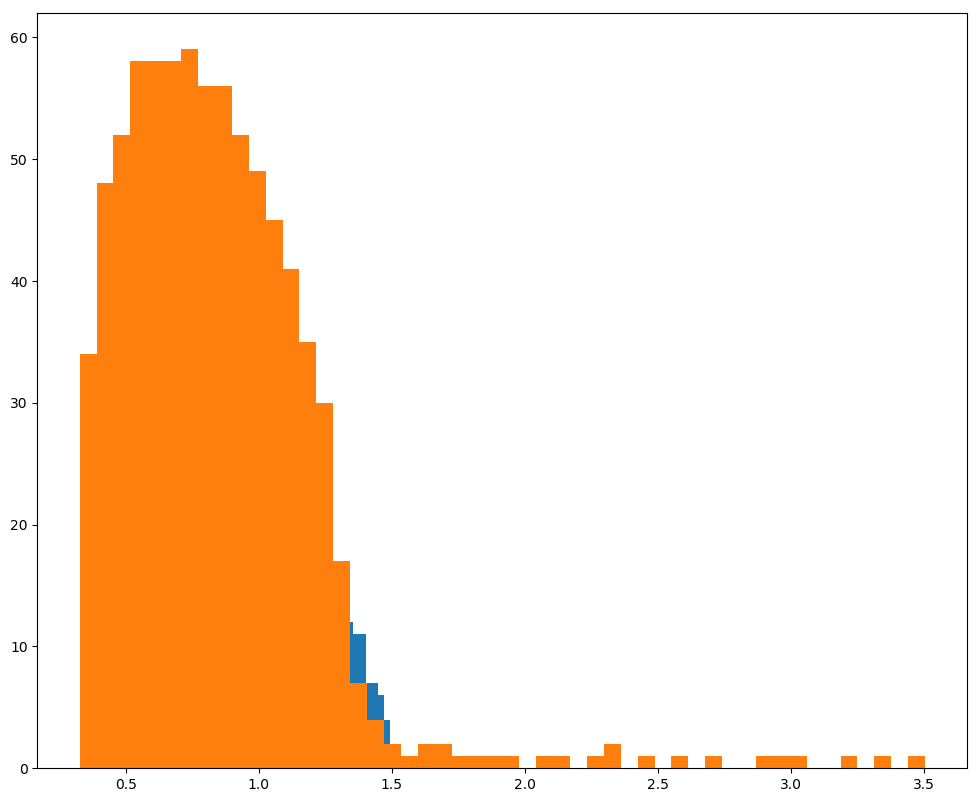

/home/anokhin/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


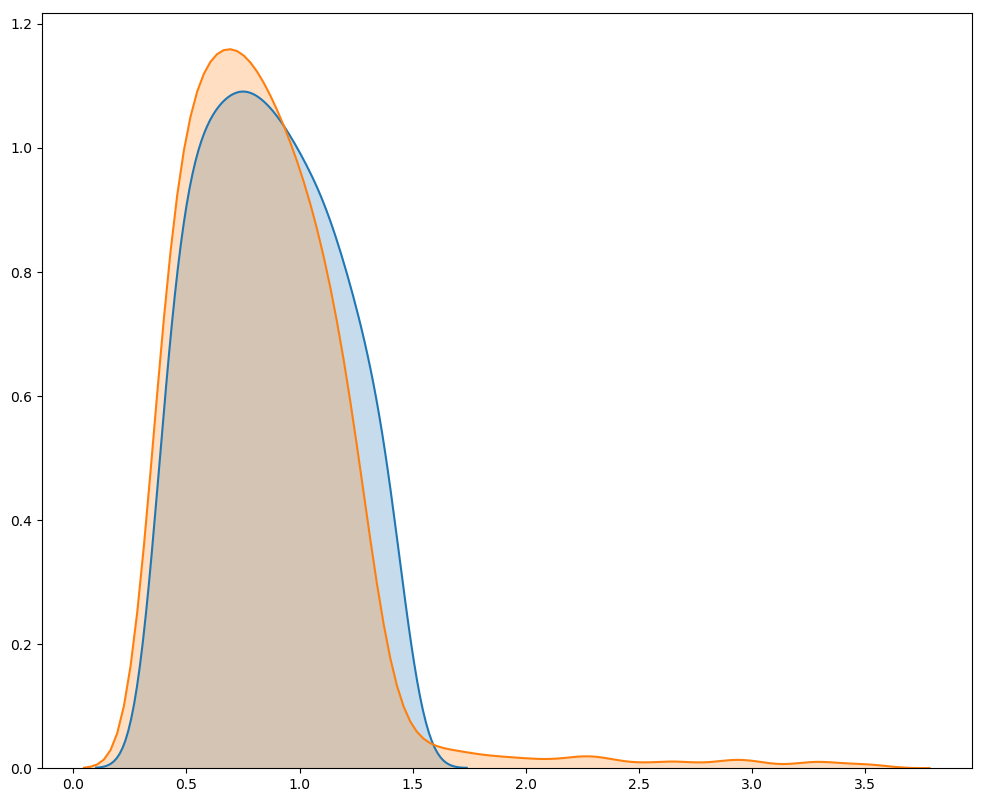

train models eigenvector heatmap


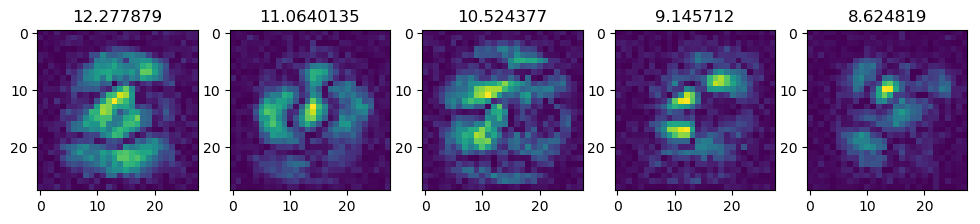

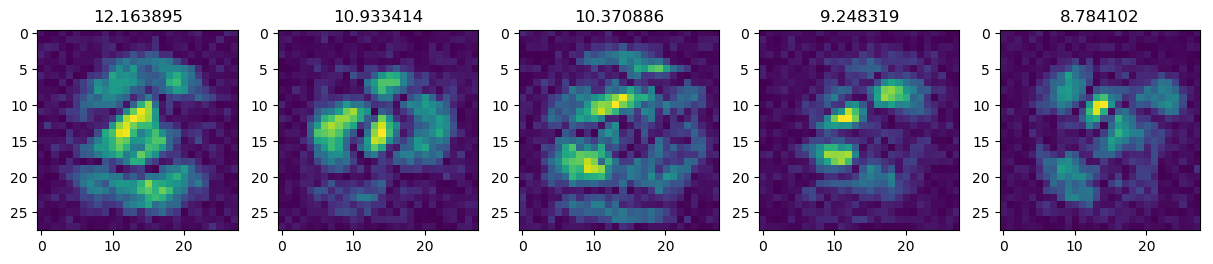

scalar product between train models
norms w1, w2 28.272017 28.281408
cos 0.0029618354
neurons distributions...
train distribution in 500 pixel


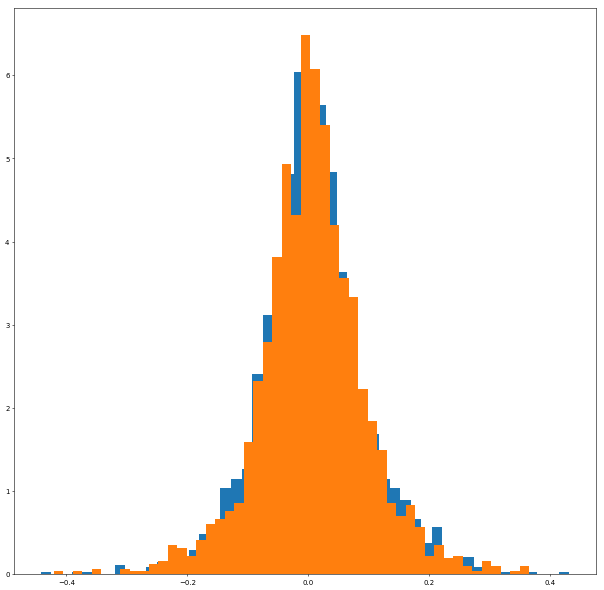

train distribution in 1 pixel


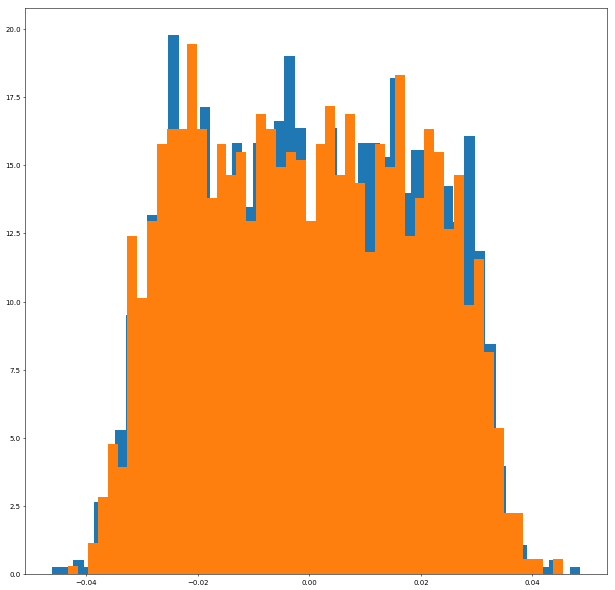

distribution in 500 pixel, train and initial model1 


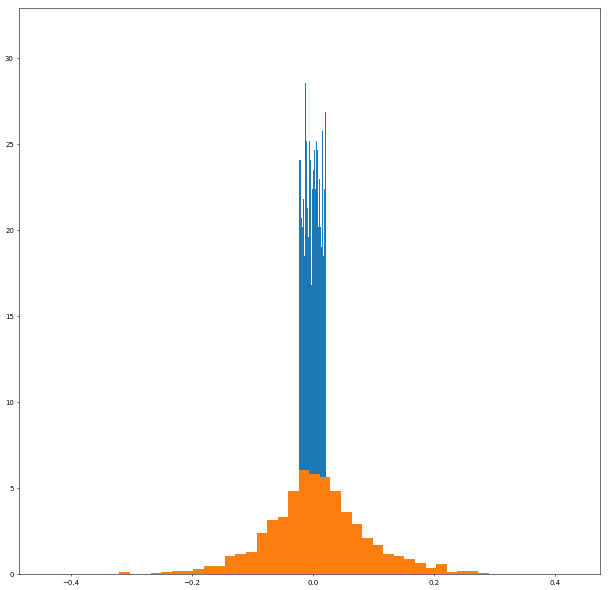

distribution in 500 pixel, train and initial model2 


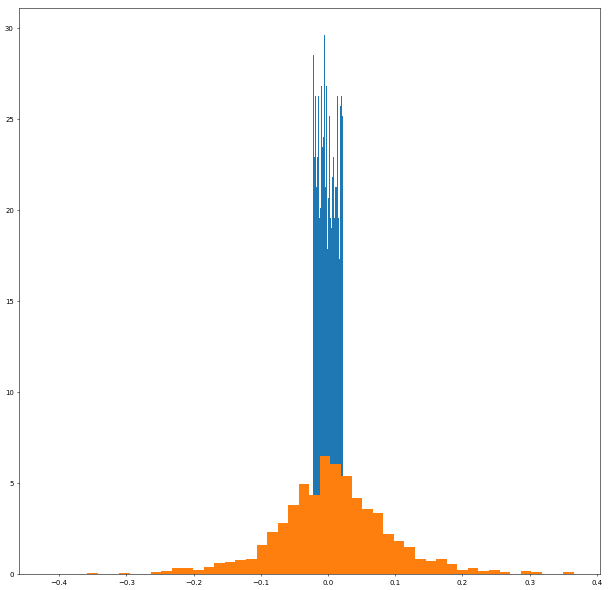

distribution in 1 pixel, train and initial model1 


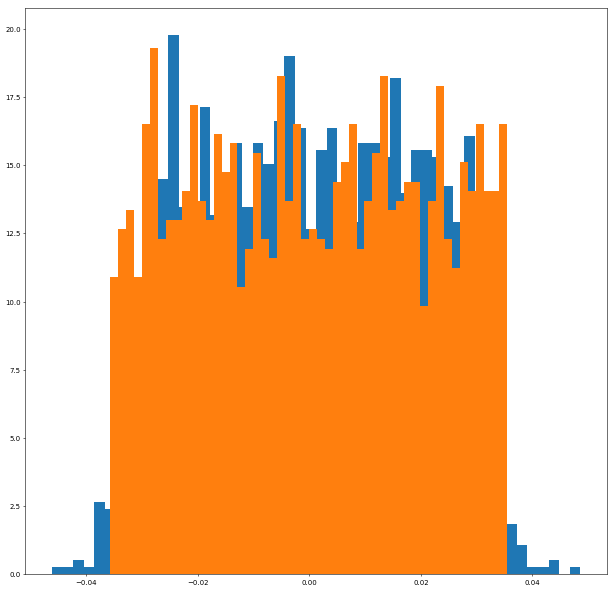

distribution in 1 pixel, train and initial model2 


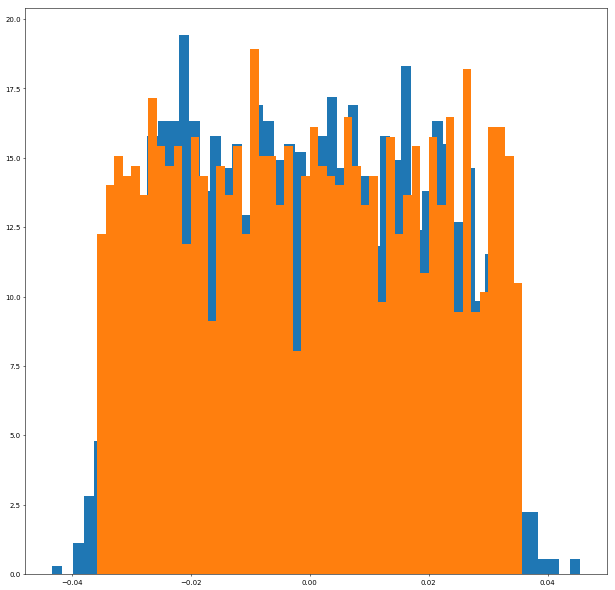

initial distributions in 1 pixel


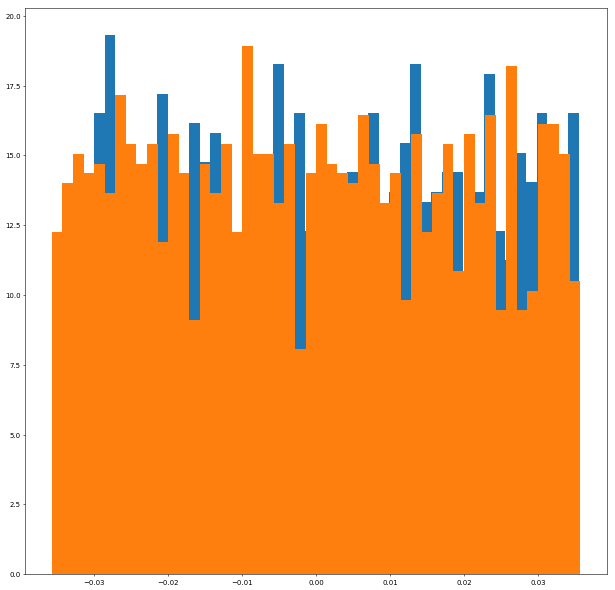

finding means for the models...
test model1
{'nll': 0.04309506346881389, 'loss': 0.04309506346881389, 'accuracy': 99.01833333333333}
{'nll': 0.07010492646694183, 'loss': 0.07010492646694183, 'accuracy': 97.96}
test model2
{'nll': 0.04299221715132395, 'loss': 0.04299221715132395, 'accuracy': 99.02166666666666}
{'nll': 0.06919561448097229, 'loss': 0.06919561448097229, 'accuracy': 97.81}
computing Arc2 model...
test Arc2
{'nll': 0.08462955683072408, 'loss': 0.08462955683072408, 'accuracy': 97.75833333333334}
{'nll': 0.10701955115795135, 'loss': 0.10701955115795135, 'accuracy': 96.98}
computing Arc model...
test Arc
{'nll': 0.08462956264813741, 'loss': 0.08462956264813741, 'accuracy': 97.75833333333334}
{'nll': 0.10701955692768098, 'loss': 0.10701955692768098, 'accuracy': 96.98}
computing Lin model...
{'nll': 0.2622267635345459, 'loss': 0.2622267635345459, 'accuracy': 96.62333333333333}
{'nll': 0.26579342799186706, 'loss': 0.26579342799186706, 'accuracy': 95.97}


In [17]:
model1.load_state_dict(torch.load('curves_mnist/LinearOneLayer/LongTraining//curve5/checkpoint-30.pt')['model_state'])
model2.load_state_dict(torch.load('curves_mnist/LinearOneLayer/LongTraining//curve6/checkpoint-30.pt')['model_state'])

model3.load_state_dict(torch.load('curves_mnist/LinearOneLayer/LongTraining/curve5/checkpoint-0.pt')['model_state'])
model4.load_state_dict(torch.load('curves_mnist/LinearOneLayer/LongTraining/curve6/checkpoint-0.pt')['model_state'])

look_at_models(model1, model2, model3, model4, architecture)

distance between train models 38.311127
distance between initial models 36.605488
how far model1 go 37.460575
how far model2 go 37.415936
initial singular values
train singular values
singular values distribution


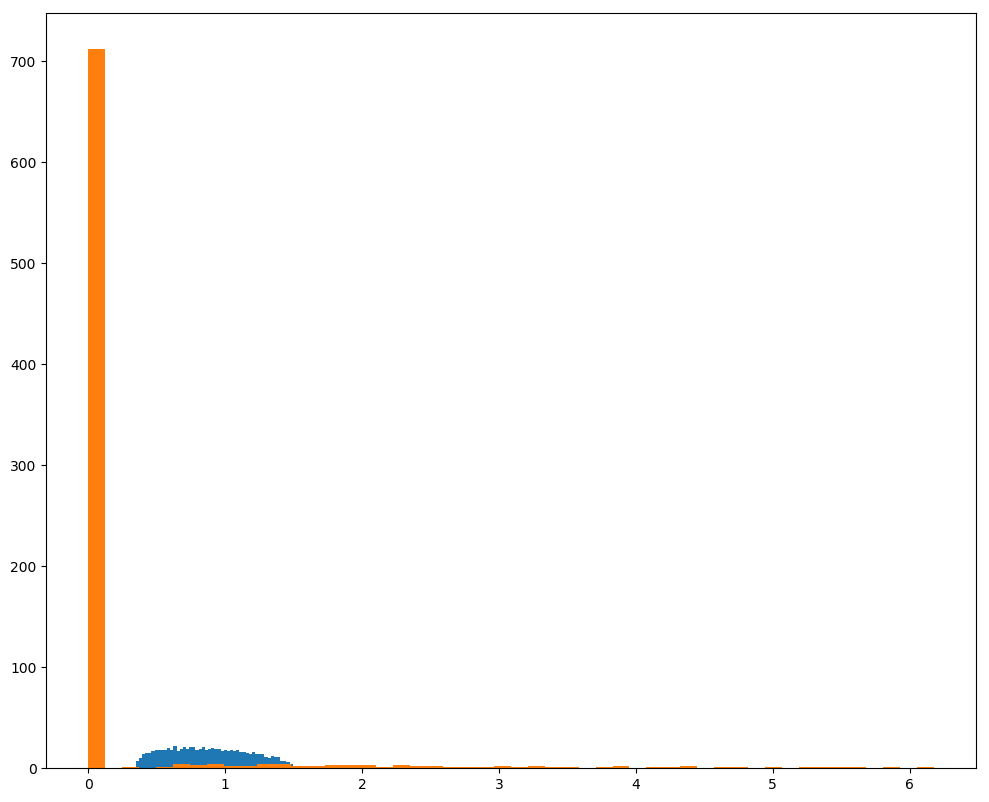

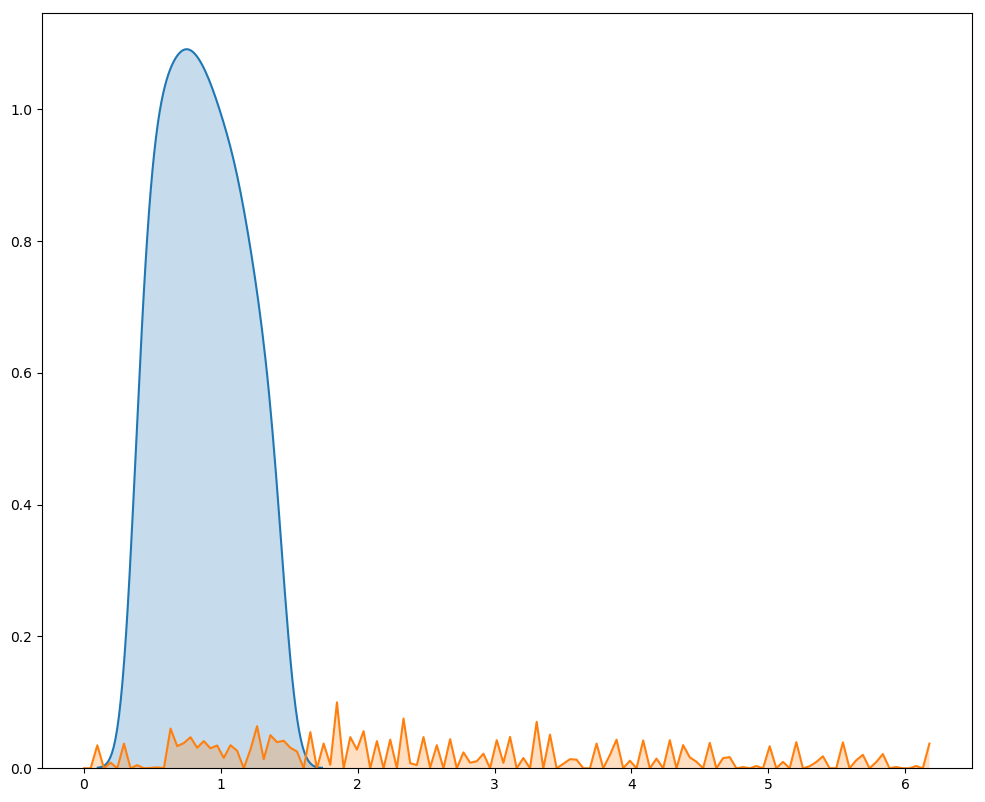

train models eigenvector heatmap


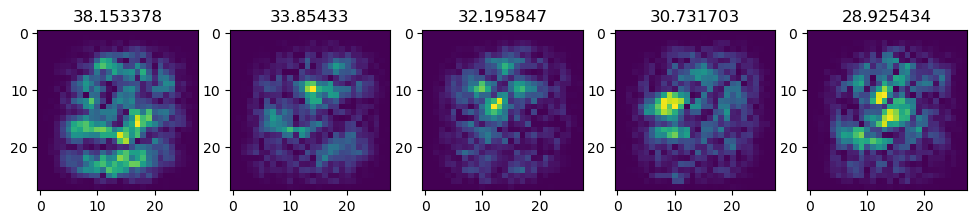

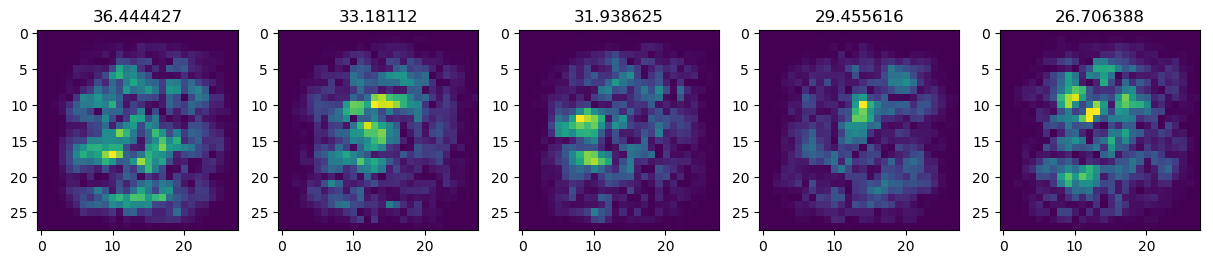

scalar product between train models
norms w1, w2 27.177952 27.135677
cos 0.004911071
neurons distributions...
train distribution in 500 pixel


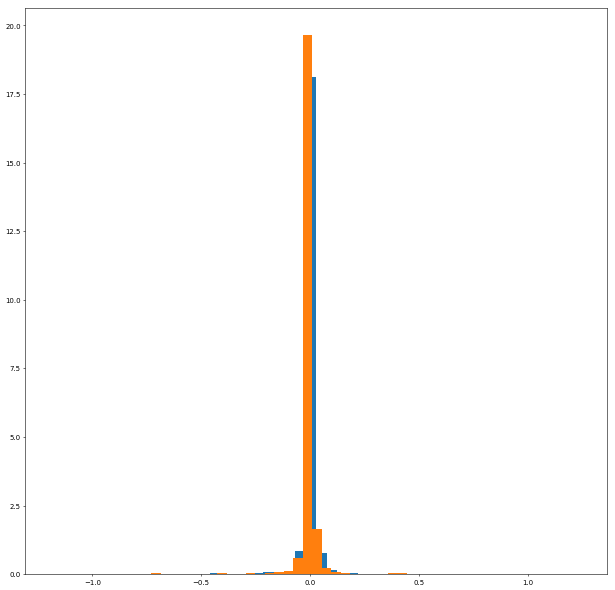

train distribution in 1 pixel


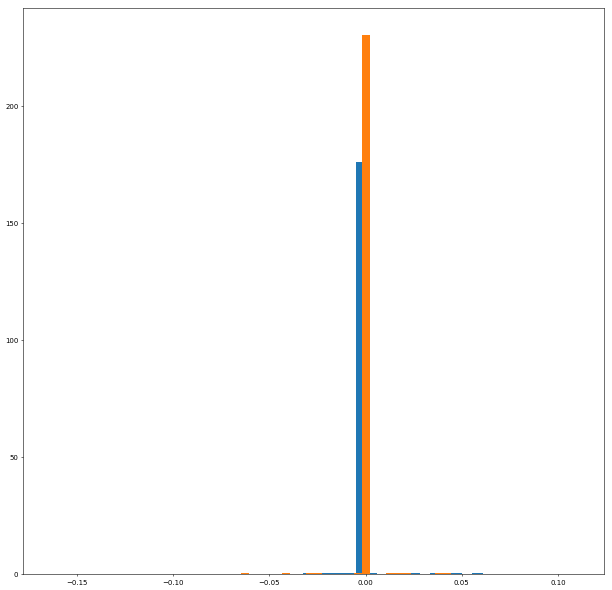

distribution in 500 pixel, train and initial model1 


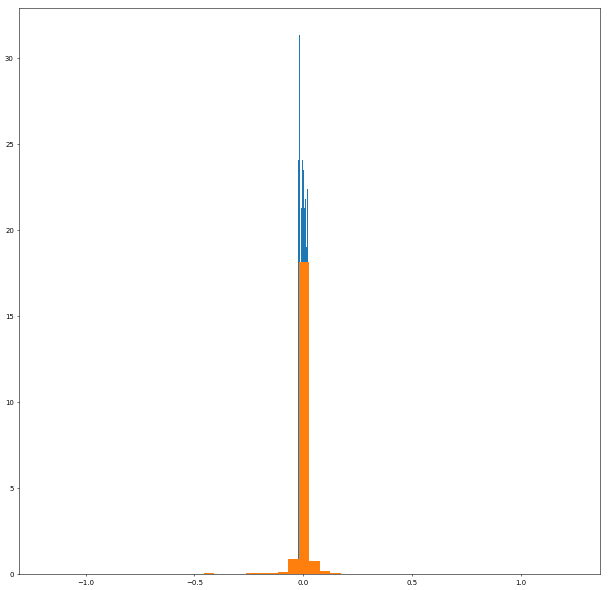

distribution in 500 pixel, train and initial model2 


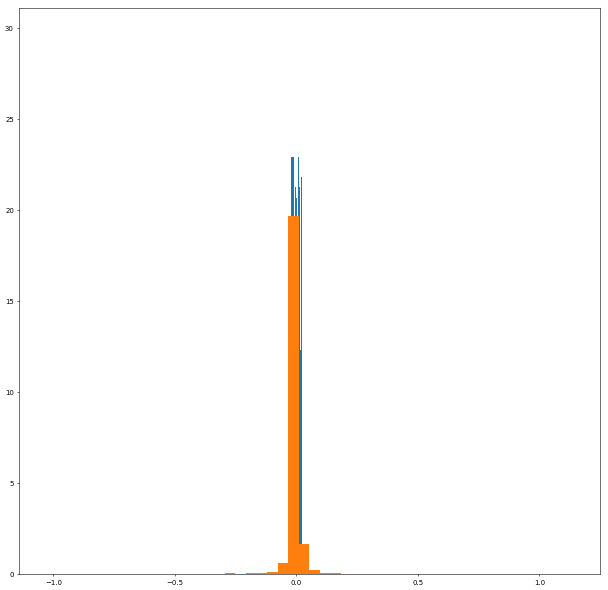

distribution in 1 pixel, train and initial model1 


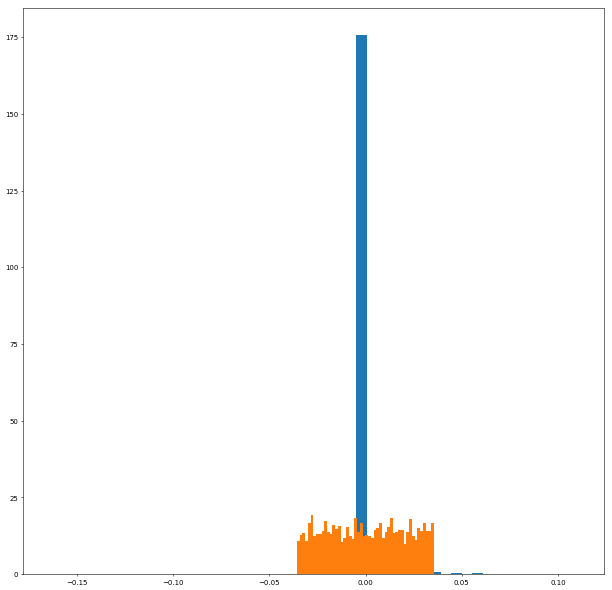

distribution in 1 pixel, train and initial model2 


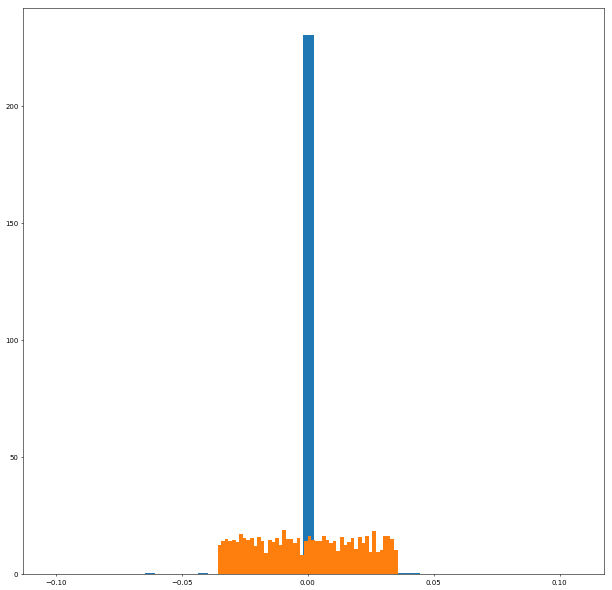

initial distributions in 1 pixel


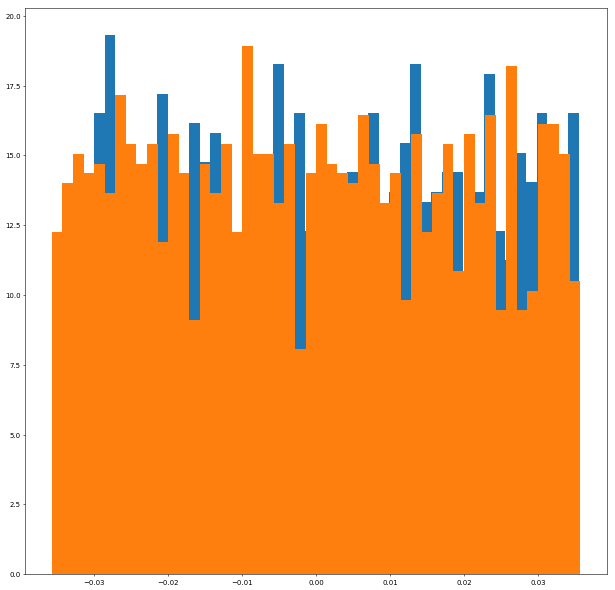

finding means for the models...
test model1
{'nll': 0.01322651330580314, 'loss': 0.01322651330580314, 'accuracy': 99.80666666666667}
{'nll': 0.059089827513694765, 'loss': 0.059089827513694765, 'accuracy': 98.14}
test model2
{'nll': 0.012396730812390646, 'loss': 0.012396730812390646, 'accuracy': 99.82833333333333}
{'nll': 0.05553358361721039, 'loss': 0.05553358361721039, 'accuracy': 98.37}
computing Arc2 model...
test Arc2
{'nll': 0.016384912725289663, 'loss': 0.016384912725289663, 'accuracy': 99.67833333333333}
{'nll': 0.05703975937366486, 'loss': 0.05703975937366486, 'accuracy': 98.13}
computing Arc model...
test Arc
{'nll': 0.016384913303951424, 'loss': 0.016384913303951424, 'accuracy': 99.67833333333333}
{'nll': 0.05703976142406464, 'loss': 0.05703976142406464, 'accuracy': 98.13}
computing Lin model...
{'nll': 0.07027011463840803, 'loss': 0.07027011463840803, 'accuracy': 99.59166666666667}
{'nll': 0.09578587112426758, 'loss': 0.09578587112426758, 'accuracy': 98.09}


In [227]:
model1.load_state_dict(torch.load('curves_mnist/LinearOneLayer/Adam/curve5/checkpoint-30.pt')['model_state'])
model2.load_state_dict(torch.load('curves_mnist/LinearOneLayer/Adam/curve6/checkpoint-30.pt')['model_state'])

model3.load_state_dict(torch.load('curves_mnist/LinearOneLayer/Adam/curve5/checkpoint-0.pt')['model_state'])
model4.load_state_dict(torch.load('curves_mnist/LinearOneLayer/Adam/curve6/checkpoint-0.pt')['model_state'])

look_at_models(model1, model2, model3, model4, architecture)